# [RSNA 2023 Abdominal Trauma Detection](https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection)

![](https://www.kaggle.com/competitions/52254/images/header)

# Idea:
* we will classify `Detect and classify traumatic abdominal injuries` from CT scans.
* We'll maximize the `binary_cross_entropy` score using as it similar to `log_loss`. ('log_loss'가 현재 데이터셋의 공식 성능 평가 지표)

# Install Libraries

In [1]:
!pip install -q keras-cv-attention-models
!pip install -qU scikit-learn
!pip install -q seaborn

# Import Libraries

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import sklearn
import matplotlib.pyplot as plt
import yaml

from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import torch
from torchvision import transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

from PIL import Image
from IPython import display as ipd
from IPython.display import display
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Seed for reproducibility

In [9]:
def seeding(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('seeding done!!!')

seeding(42)

seeding done!!!


In [10]:
BASE_PATH = f'/kaggle/input/rsna-atd-512x512-png-v2-dataset' #이미 png 파일로 변경된 dataset

# Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [11]:
# train
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images'\
                    + '/' + df.patient_id.astype(str)\
                    + '/' + df.series_id.astype(str)\
                    + '/' + df.instance_number.astype(str) +'.png'
df = df.drop_duplicates()
print('Train:')
display(df.head(2))

# test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.series_id.astype(str)\
                    + '/' + test_df.instance_number.astype(str) +'.png'
test_df = test_df.drop_duplicates()
print('\nTest:')
display(test_df.head(2))

Train:


patient_id  bowel_healthy  bowel_injury  extravasation_healthy  \
0       10004              1             0                      0   
1       10004              1             0                      0   

   extravasation_injury  kidney_healthy  kidney_low  kidney_high  \
0                     1               0           1            0   
1                     1               0           1            0   

   liver_healthy  liver_low  ...  spleen_healthy  spleen_low  spleen_high  \
0              1          0  ...               0           0            1   
1              1          0  ...               0           0            1   

   any_injury  series_id  instance_number           injury_name  \
0           1      21057              362  Active_Extravasation   
1           1      21057              363  Active_Extravasation   

                                          image_path width  height  
0  /kaggle/input/rsna-atd-512x512-png-v2-dataset/...   512     512  
1  /kaggle/input/rsna-atd-512x512-png-v2-dataset/...   512     512  

[2 rows x 21 columns]


Test:


image_path  patient_id  series_id  \
0  /kaggle/input/rsna-atd-512x512-png-v2-dataset/...       63706      39279   
1  /kaggle/input/rsna-atd-512x512-png-v2-dataset/...       50046      24574   

   instance_number  width  height  
0               30    512     512  
1               30    512     512

In [13]:
print('train_files:',df.shape[0])
print('test_files:',test_df.shape[0])

train_files: 12029
test_files: 3


# Class Dependency

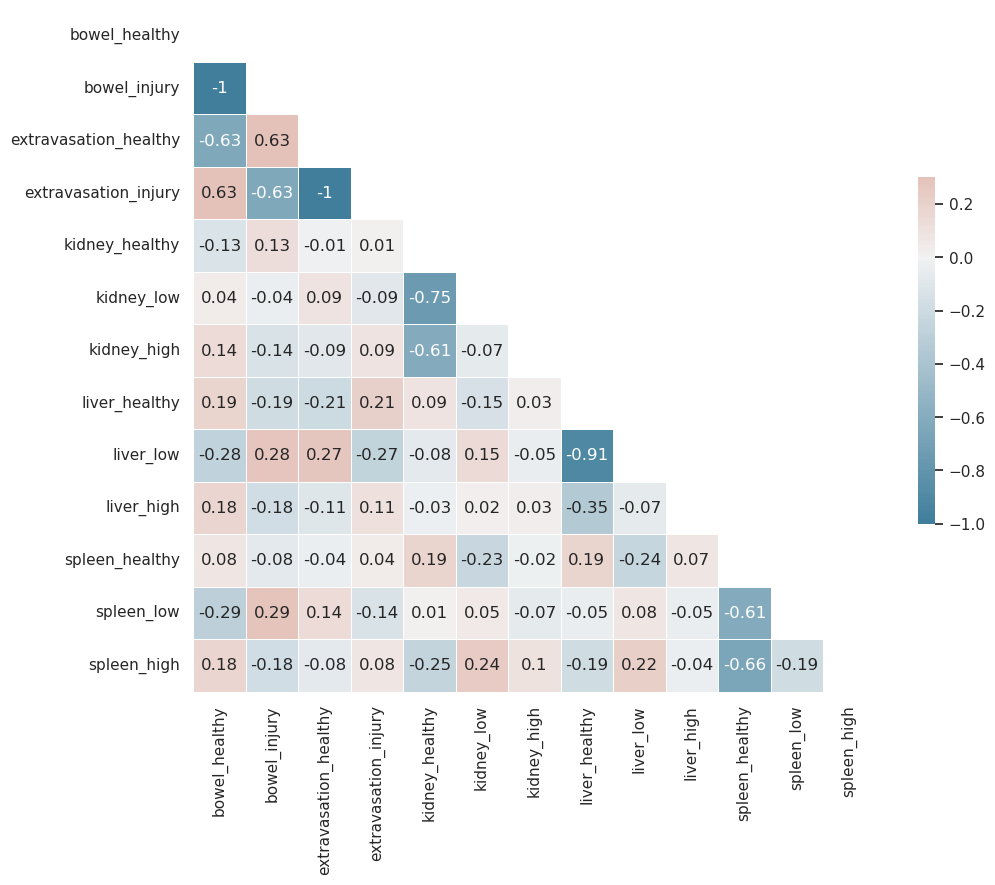

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df[df.columns[1:14]].corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show();

# Build CustomDataset & Save

In [16]:
img_list = df["image_path"].tolist()

In [17]:
target_col  = ["bowel_injury", "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

In [18]:
labels_df = df[target_col]
labels_df

bowel_injury  extravasation_injury  kidney_healthy  kidney_low  \
0                 0                     1               0           1   
1                 0                     1               0           1   
2                 0                     1               0           1   
3                 0                     1               0           1   
4                 0                     1               0           1   
...             ...                   ...             ...         ...   
13010             0                     1               1           0   
13011             0                     1               1           0   
13012             0                     1               1           0   
13013             0                     1               1           0   
13014             0                     1               1           0   

       kidney_high  liver_healthy  liver_low  liver_high  spleen_healthy  \
0                0              1          0           0               0   
1                0              1          0           0               0   
2                0              1          0           0               0   
3                0              1          0           0               0   
4                0              1          0           0               0   
...            ...            ...        ...         ...             ...   
13010            0              1          0           0               1   
13011            0              1          0           0               1   
13012            0              1          0           0               1   
13013            0              1          0           0               1   
13014            0              1          0           0               1   

       spleen_low  spleen_high  
0               0            1  
1               0            1  
2               0            1  
3               0            1  
4               0            1  
...           ...          ...  
13010           0            0  
13011           0            0  
13012           0            0  
13013           0            0  
13014           0            0  

[12029 rows x 11 columns]

In [20]:
class CustomCaptchaDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, labels_df, transform=None):
        self.img_list = img_list
        self.transform = transform
        self.labels_df = labels_df

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path = self.img_list[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels_df.iloc[idx].tolist()

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

In [21]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # 데이터의 크기를 동일하게 맞춰주기
    transforms.ToTensor(), # 각 픽셀의 값을 [0,1]
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [22]:
# 데이터셋 객체 생성
train_dataset = CustomCaptchaDataset(img_list, labels_df, transform=transform_train)

In [23]:
import pickle

# Save the paths and labels from your dataset
dataset_info = {
    'img_list': train_dataset.img_list,
    'labels_df': train_dataset.labels_df
}

# Save the dataset info to a file using pickle
with open('custom_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_info, f)

In [24]:
with open('custom_dataset.pkl', 'rb') as f:
    dataset_info = pickle.load(f)

# Create a new instance of your custom dataset using the loaded info
loaded_dataset = CustomCaptchaDataset(
    img_list=dataset_info['img_list'],
    labels_df=dataset_info['labels_df'],
    transform=transform_train
)

In [25]:
# 데이터셋 정보 로드
train_dataloader = DataLoader(loaded_dataset, batch_size=64, shuffle=True)
train_dataloader

In [26]:
for (inputs, labels) in train_dataloader:
    print(inputs.shape) # [batch_size, channel, width, height]
    print(labels.shape) # [batch_size, digits_size]

    break

torch.Size([64, 3, 256, 256])
torch.Size([64, 11])


# Augmentation & Split Dataset

In [27]:
img_list=dataset_info['img_list']
labels_df=dataset_info['labels_df']

In [28]:
from sklearn.model_selection import train_test_split
train_data_list, val_data_list, train_labels, val_labels = train_test_split(
    img_list, labels_df, test_size=0.2, random_state=42
)

In [29]:
# 학습 데이터 데이터 증진(data augmentation)
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # 데이터의 크기를 동일하게 맞춰주기
    transforms.RandomHorizontalFlip(), # 데이터 증진
    transforms.ToTensor(), # 각 픽셀의 값을 [0, 1]
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [30]:
train_dataset = CustomCaptchaDataset(train_data_list, train_labels, transform=transform_train)
val_dataset = CustomCaptchaDataset(val_data_list, val_labels, transform=transform_val)

# DataLoader for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

학습 데이터 개수: 9623


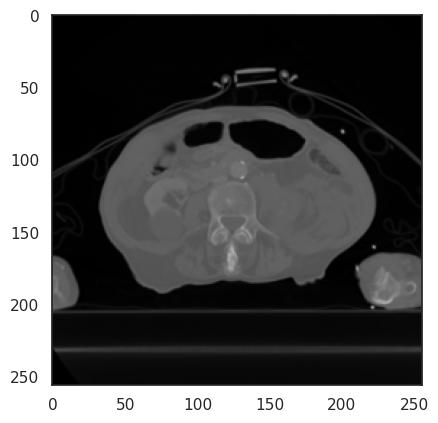

tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0])


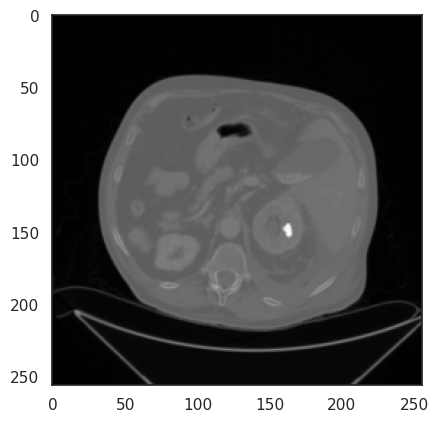

tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0])


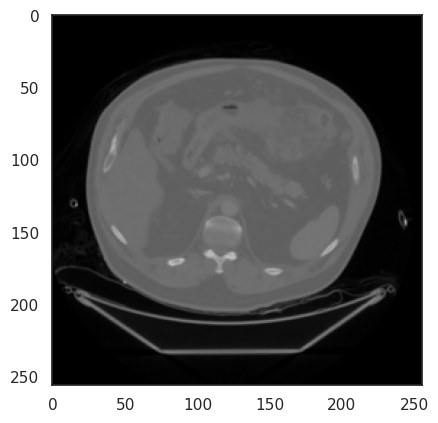

tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0])


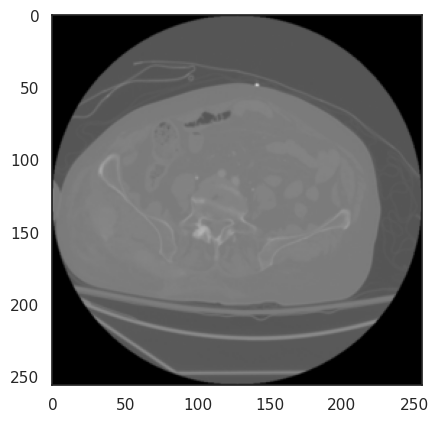

tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0])


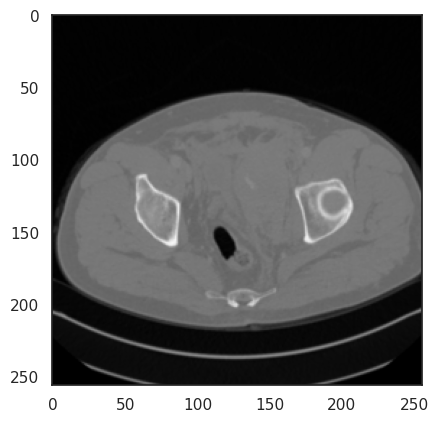

tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0])


In [31]:
def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.show()

print(f"학습 데이터 개수: {len(train_dataset)}")

iterator = iter(train_dataloader)
imgs, labels = next(iterator)

for i in range(5):
    imshow(imgs[i])
    print(labels[i])

# Build Model

In [33]:
import time

learning_rate = 0.001
log_step = 100
n_classes = 11
num_epochs = 10

model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
model = model.cuda()

bce_loss = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
ce_loss = nn.CrossEntropyLoss()  # Categorical Cross Entropy Loss

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0
    
    for step, (images, labels) in enumerate(train_dataloader):
        images = images.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        # 모델 예측
        outputs = model(images)
        
        # 손실 계산
        loss_bce = bce_loss(outputs[:, 0:1], labels[:, 0:1].float())  # Binary Cross Entropy
        loss_bce2 = bce_loss(outputs[:, 1:2], labels[:, 1:2].float())  # Binary Cross Entropy
        
        loss_ce1 = ce_loss(outputs[:, 2:5], labels[:, 2:5].argmax(dim=1))
        loss_ce2 = ce_loss(outputs[:, 5:8], labels[:, 5:8].argmax(dim=1))
        loss_ce3 = ce_loss(outputs[:, 8:11], labels[:, 8:11].argmax(dim=1))
        total_loss = loss_bce + loss_bce2 + loss_ce1 + loss_ce2 + loss_ce3
        
        total_train_loss += total_loss.item()
        
        # 정확도 계산
        _, predicted = torch.max(outputs[:, 2:11], 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels[:, 2:11].argmax(dim=1)).sum().item()
        
        total_loss.backward()
        optimizer.step()
        
        if step % log_step == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch}/{num_epochs}], Step [{step}/{len(train_dataloader)}], "
                  f"Loss: {total_loss.item():.4f}, Elapsed Time: {elapsed_time:.2f} seconds")
    
    train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = 100 * train_correct / train_total
    
    # Validation
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = model(images)
            
            loss_bce = bce_loss(outputs[:, 0:1], labels[:, 0:1].float())  # Binary Cross Entropy
            loss_bce2 = bce_loss(outputs[:, 1:2], labels[:, 1:2].float())  # Binary Cross Entropy
            
            loss_ce1 = ce_loss(outputs[:, 2:5], labels[:, 2:5].argmax(dim=1))
            loss_ce2 = ce_loss(outputs[:, 5:8], labels[:, 5:8].argmax(dim=1))
            loss_ce3 = ce_loss(outputs[:, 8:11], labels[:, 8:11].argmax(dim=1))
            total_loss = loss_bce + loss_bce2 + loss_ce1 + loss_ce2 + loss_ce3
            
            total_val_loss += total_loss.item()
            
            _, predicted = torch.max(outputs[:, 2:11], 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels[:, 2:11].argmax(dim=1)).sum().item()
    
    val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = 100 * val_correct / val_total
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    
    elapsed_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
          f"Elapsed Time: {elapsed_time:.2f} seconds")

print("Training finished!")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 87.9MB/s] 


Epoch [0/10], Step [0/1203], Loss: 4.7333, Elapsed Time: 0.21 seconds
Epoch [0/10], Step [100/1203], Loss: 1.3713, Elapsed Time: 27.78 seconds
Epoch [0/10], Step [200/1203], Loss: 0.5531, Elapsed Time: 54.95 seconds
Epoch [0/10], Step [300/1203], Loss: 0.5453, Elapsed Time: 83.13 seconds
Epoch [0/10], Step [400/1203], Loss: 2.5597, Elapsed Time: 110.81 seconds
Epoch [0/10], Step [500/1203], Loss: 1.1822, Elapsed Time: 138.37 seconds
Epoch [0/10], Step [600/1203], Loss: 0.3877, Elapsed Time: 165.53 seconds
Epoch [0/10], Step [700/1203], Loss: 0.1001, Elapsed Time: 192.75 seconds
Epoch [0/10], Step [800/1203], Loss: 0.7665, Elapsed Time: 220.03 seconds
Epoch [0/10], Step [900/1203], Loss: 1.2156, Elapsed Time: 247.97 seconds
Epoch [0/10], Step [1000/1203], Loss: 0.7493, Elapsed Time: 275.16 seconds
Epoch [0/10], Step [1100/1203], Loss: 0.1672, Elapsed Time: 303.26 seconds
Epoch [0/10], Step [1200/1203], Loss: 0.0263, Elapsed Time: 330.46 seconds
Epoch [0/10], Train Loss: 0.8127, Train Ac

# Inference